# Challenge 1 - Low Conversion

## 1️⃣ Intro
### 🕵️‍♀️ Investigate Low Conversion Listings

Hello, fellow SP-API experts!


I am writing to you on behalf of the 🪄ListingsWizard company. <br />
In recent reporting, we noticed **something unusual** with our Listings Sales Conversion. <br />
Can you please investigate and recover the sales? My team has provided data access below to assist your investigation.


Yours,
ListingsWizard

---

_* The following scenario uses a mock server and mock data. No real data is used._

### Your Quest
1. Analyze data 📈
2. Identify root cause 👀
3. Submit a fix 🔧

On correct submission, you will receive a passcode. First person to receive the correct passcode will be the 🪄 **Wizard of Glory** 💫💫💫


## 2️⃣ Setup
### 🧰 Installing Selling Partner API SDK

The **Amazon Selling Partner API SDK** is an official Amazon library that simplifies integration with Amazon’s SP-API. It handles things like authentication, request signing, and response parsing — so you can focus on building your solution instead of dealing with low-level API mechanics.

With this SDK, you can easily access endpoints like Orders, Listings, Reports, Feeds, and **Buy Shipping** using clean, structured Python code.

📚 Learn more or explore the source on GitHub: https://github.com/amzn/selling-partner-api-sdk/tree/main


📦 To install the SDK, run the below block 👇

In [1]:
pip install amzn-sp-api

Looking in indexes: https://pypi.org/simple, https://plugin.us-east-1.prod.workshops.aws

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


---

# 3️⃣ Challenge

## 📊 Let's Data Kiosk!

Data Kiosk lets you submit GraphQL queries from a variety of schemas to help manage selling partner businesses. You can use the following SDK to call Data Kiosk API.


### 🔍 What is Data Kiosk?

It’s your all-access pass to query Amazon datasets like sales, traffic, and profitability using GraphQL.

You can:

- Submit custom queries
- Check their status
- Download results
  
🙌 Time to get seller data with the power of GraphQL!



---

### 🐛 Mocking the SDK


Luckily the Amazon Solution Architect team created a mock server that can replicate the API responses without having credentials.

Below you will find `mock_oauth_endpoint` and `mock_endpoint` variables that can be used to skip the credentials.

In [7]:
from spapi.models.datakiosk_v2023_11_15 import GetDocumentResponse, CreateQueryResponse, GetQueriesResponse, Query
from spapi import SPAPIConfig, SPAPIClient, ApiException, QueriesApi, ListingsApi

# Configuration for mock SP-API
mock_oauth_endpoint = "http://127.0.0.1:8001/auth/o2/token"
mock_endpoint = "http://127.0.0.1:8001"

config = SPAPIConfig(
    client_id="Chris",
    client_secret="Khoury",
    refresh_token="FakeToken",
    region="NA"
)
client = SPAPIClient(config, endpoint=mock_endpoint, oauth_endpoint=mock_oauth_endpoint)

data_kiosk_api = QueriesApi(client.api_client)
listings_api = ListingsApi(client.api_client)

---

### 🚶‍♂️ Steps to Get Data Kiosk Reports

#### 🖥️ Step 1: Paste Your Query Below

💡 Use the [Data Kiosk Schema Explorer UI](https://sellercentral.amazon.com/datakiosk-schema-explorer?schema=analytics_salesAndTraffic_2024_04_24) to build your perfect query, for now, you can use the one we built for you here:

In [8]:
graphql_query_str = ("query { analytics_economics_2024_03_15 { economics( marketplaceIds: [\"ATVPDKIKX0DER\"], "
                 "startDate: \"2025-06-01\", endDate: \"2025-06-05\", "
                 "aggregateBy: { date: DAY, productId: MSKU } ) "
                 "{ startDate endDate msku marketplaceId sales { unitsOrdered netUnitsSold "
                 "netProductSales { amount currencyCode } } netProceeds { total { amount currencyCode } } } } }")
graphql_query = {"query": graphql_query_str}

---

#### 🚀 Step 2: Send the Query
Let Amazon know you’re ready to roll by calling `create_query`.

In [9]:
# Tell Amazon to start processing your query
create_query_response = data_kiosk_api.create_query(body=graphql_query)
print("✅ Query submitted! Response:", create_query_response)

✅ Query submitted! Response: {'query_id': '1000001'}


---

#### ⏳ Step 3: Check If Your Data Is Ready

You can either:

- Keep checking with `get_query`, or
- 🧠 Be smart _well-architected_ and subscribe to the [DATA_KIOSK_QUERY_PROCESSING_FINISHED](https://developer-docs.amazon.com/sp-api/docs/data-kiosk-notification) notification for automatic updates.

Here, we’ll use polling just once for simplicity - if data is ready a `dataDocumentId` attribute will be reutrned:

In [10]:
# Check the status of your query
get_query_response = data_kiosk_api.get_query(query_id=create_query_response.query_id)
print("⏱️ Query status:", get_query_response)

⏱️ Query status: {'created_time': datetime.datetime(2025, 7, 17, 11, 25, 13, 645000, tzinfo=tzutc()),
 'data_document_id': 'usecase_1_document_id.amzn.100001',
 'error_document_id': None,
 'pagination': None,
 'processing_end_time': datetime.datetime(2025, 7, 17, 11, 25, 13, 645000, tzinfo=tzutc()),
 'processing_start_time': datetime.datetime(2025, 7, 17, 11, 25, 13, 645000, tzinfo=tzutc()),
 'processing_status': 'DONE',
 'query': 'query { analytics_economics_2024_03_15 { economics( marketplaceIds: '
          '["ATVPDKIKX0DER"], startDate: "2025-06-01", endDate: "2025-06-05", '
          'aggregateBy: { date: DAY, productId: MSKU } ) { startDate endDate '
          'msku marketplaceId sales { unitsOrdered netUnitsSold '
          'netProductSales { amount currencyCode } } netProceeds { total { '
          'amount currencyCode } } } } }',
 'query_id': '1000001'}


---

#### 📦 Step 4: Get Your Data!

Once the query is ready, you’ll receive a `dataDocumentId`. Use it to grab the results with `get_document` endpoint.

In [11]:
# Now let's get the actual data!
get_document = data_kiosk_api.get_document(document_id=get_query_response.data_document_id)
print("📊 Here's your data:", get_document)

📊 Here's your data: {'document_id': 'usecase_1_document_id.amzn.100001',
 'document_url': "{'data': {'analytics_economics_2024_03_15': {'economics': "
                 "[{'startDate': '2025-06-01', 'endDate': '2025-06-01', "
                 "'msku': 'MOTOR-GEAR-US', 'marketplaceId': 'ATVPDKIKX0DER', "
                 "'sales': {'unitsOrdered': 0, 'netUnitsSold': 0, "
                 "'netProductSales': {'amount': 0.0, 'currencyCode': 'USD'}}, "
                 "'netProceeds': {'total': {'amount': 0.0, 'currencyCode': "
                 "'USD'}}}, {'startDate': '2025-06-01', 'endDate': "
                 "'2025-06-01', 'msku': 'MOTOR-GEAR-CA', 'marketplaceId': "
                 "'A2EUQ1WTGCTBG2', 'sales': {'unitsOrdered': 50, "
                 "'netUnitsSold': 50, 'netProductSales': {'amount': 1000.0, "
                 "'currencyCode': 'CAD'}}, 'netProceeds': {'total': {'amount': "
                 "800.0, 'currencyCode': 'CAD'}}}, {'startDate': '2025-06-01', "
                 "

---

### 📊 Visualize Your Economics Data

Let’s bring the numbers to life!

Below, we’ll:
- Parse the economics data from `get_document_response`
- Build a DataFrame
- Plot net product sales and units sold per MSKU

Make sure you’ve run the cell above so `get_document_response` is available.


🧾 Parsed Economics Data:


,MSKU,Start Date,End Date,Net Product Sales ($),Units Sold
0,MOTOR-GEAR-US,2025-06-01,2025-06-01,0.0,0
1,MOTOR-GEAR-CA,2025-06-01,2025-06-01,1000.0,50
2,MOTOR-GEAR-MX,2025-06-01,2025-06-01,1000.0,50


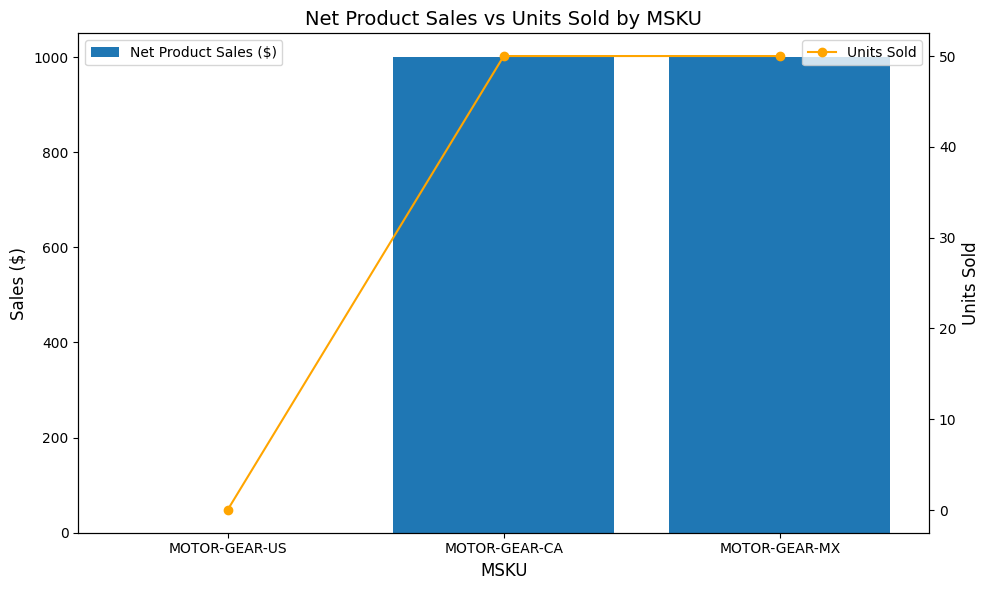

In [12]:
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Safely convert the string to a dictionary
parsed_document = ast.literal_eval(get_document.document_url)

# Extract the economics data
economics_data = parsed_document["data"]["analytics_economics_2024_03_15"]["economics"]

# Build a DataFrame
df = pd.DataFrame([
    {
        "MSKU": item["msku"],
        "Start Date": item["startDate"],
        "End Date": item["endDate"],
        "Net Product Sales ($)": item["sales"]["netProductSales"]["amount"],
        "Units Sold": item["sales"]["netUnitsSold"]
    }
    for item in economics_data
])

# Show the raw data
print("🧾 Parsed Economics Data:")
display(df)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for Net Product Sales
ax1.bar(df["MSKU"], df["Net Product Sales ($)"], label='Net Product Sales ($)')
ax1.set_ylabel("Sales ($)", fontsize=12)
ax1.set_title("Net Product Sales vs Units Sold by MSKU", fontsize=14)
ax1.set_xlabel("MSKU", fontsize=12)
ax1.legend(loc="upper left")

# Line chart for Units Sold
ax2 = ax1.twinx()
ax2.plot(df["MSKU"], df["Units Sold"], color='orange', marker='o', label='Units Sold')
ax2.set_ylabel("Units Sold", fontsize=12)
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


---

## 4️⃣ Troubleshooting: 

### 🫆 Clue

Looks like all the SKUs with the `POWERSPORTS_PROTECTIVE_GEAR` product type are experiencing low sales in the US marketplace! Interestingly, the same SKUs are performing quite well in Canada and Mexico, which suggests there may be an issue specific to the US marketplace. 

Use the code below to call getListingsItems operation on one of the SKUs with the `POWERSPORTS_PROTECTIVE_GEAR` product type in the US to investigate further. 


In [14]:
import json
get_listing = listings_api.get_listings_item('AMY6FKRUBY7XV', 
                                             'MOTOR-GEAR-US',
                                             ['ATVPDKIKX0DER'], 
                                             included_data=['issues'])

print("🛍️ Here's your listing: \n", json.dumps(get_listing.to_dict(), indent=4, default=str))

🛍️ Here's your listing: 
 {
    "sku": "BICYCLEY-GRAY-M",
    "summaries": [
        {
            "marketplace_id": "ATVPDKIKX0DER",
            "asin": "B0B135FM7W",
            "product_type": "BICYCLE",
            "condition_type": "new_new",
            "status": [
                "BUYABLE",
                "DISCOVERABLE"
            ],
            "fn_sku": null,
            "item_name": "Sense Montain Bike Rim 29 One 2021/2022 - Frame Size M - Color Gray/Green",
            "created_date": "2024-11-27 19:16:58.550000+00:00",
            "last_updated_date": "2024-11-27 20:55:31.010000+00:00",
            "main_image": {
                "link": "https://m.media-amazon.com/images/I/418Drwj6xiL.jpg",
                "height": 331,
                "width": 500
            }
        }
    ],
    "attributes": {
        "suspension_type": [
            {
                "language_tag": "en_US",
                "value": "Rear",
                "marketplace_id": "ATVPDKIKX0DER"
       

### New Clue

There is an issue on the listing: the listings have been search suppressed, making them no longer discoverable in the US marketplace. But the issue is MISSING_ATTRIBUTE which is a synchonous error. What went wrong!!? 


## 5️⃣ Resolution: 

### 🧐 Analysis

We noticed that there is an `ERROR` severity issue in getListingsItems response! And attribute is indeed missing from the attributes data. 

```
[ {
      "code" : "90220",
      "message" : "Department Name is required but was not provided.",
      "severity" : "ERROR",
      "attributeNames" : [ "department" ],
      "categories" : [ "MISSING_ATTRIBUTE" ],
      "enforcements" : {
        "actions" : [ {
          "action" : "SEARCH_SUPPRESSED"
        } ],
        "exemption" : {
          "status" : "NOT_EXEMPT"
        }
      }
    } ]
```

90220 error code usually means a required attribute is missing. But why is this only happening in the US marketplace? 

Our team pulled the putListingsItem submission. Can you observe and see why the US marketplace listings are search suppressed? Are they using right and same product type across all three submissions? 
//Add patch submissions from all three marketplaces. 

<details>
<summary><strong>💡 HINT</strong></summary>
    
_*Products should maintain the same product type across all marketplaces. While it's technically possible to assign different product types in different marketplaces, this practice often leads to complications. The catalog system may automatically reclassify your contributions, resulting in missing required attributes, incorrect variation themes, and other technical issues.*_

</details>

### 🛠️ Fix

What is this? 🔎

Our team has prepared a patchListingsItem request below. Fill out the correct attributes to update to fix the Listings Error!

In [ ]:
body = {
  "productType": "POWERSPORTS_PROTECTIVE_GEAR",
  "patches": [
    {
      "op": "replace",
      "path": "/attributes/department",
      "value": [
        {
          "language_tag": "en_US",
          "marketplace_id": 1,
          "value": "Unisex"
        }
      ]
    }
  ]
} 
patch_listing = listings_api.patch_listings_item('AMY6FKRUBY7XV', 'BICYCLE-GRAY-M',['ATVPDKIKX0DER'], body)
print("💾 Submission result: \n", json.dumps(patch_listing.to_dict(), indent=4, default=str))